In [1]:
!python --version

Python 3.9.0


# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve <font color="red">an accuracy greater than 45%</font>. If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. (Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try.)

Some of the benchmark results on CIFAR-10 include:

- 78.9% Accuracy | [**Deep Belief Networks; Krizhevsky, 2010**](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)
- 90.6% Accuracy | [**Maxout Networks; Goodfellow et al., 2013**](https://arxiv.org/pdf/1302.4389.pdf)
- 96.0% Accuracy | [**Wide Residual Networks; Zagoruyko et al., 2016**](https://arxiv.org/pdf/1605.07146.pdf)
- 99.0% Accuracy | [**GPipe; Huang et al., 2018**](https://arxiv.org/pdf/1811.06965.pdf)
- 98.5% Accuracy | [**Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020**](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list first. The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module. Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` (the documentation is available [**here**](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)). Make sure to specify `download=True`. 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# The 10 classes in the dataset
classes = trainset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Explore the Dataset

Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument. Remember that normalized images will look really weird to you. You may want to try changing your transforms to view images. Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network. If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
# Train and test data size
print(trainset.data.shape, testset.data.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [8]:
# Each image has a shape of
next(iter(trainloader))[0][0].shape

torch.Size([3, 32, 32])

In [9]:
def show5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        image = images[i].numpy()
        image = image * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(np.transpose(image, (1, 2, 0)))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    
    plt.show()

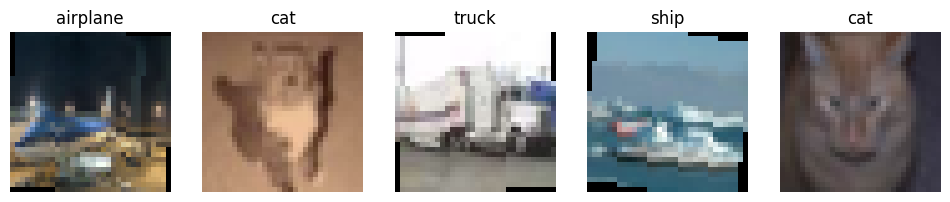

In [10]:
# Explore train data
show5(trainloader)

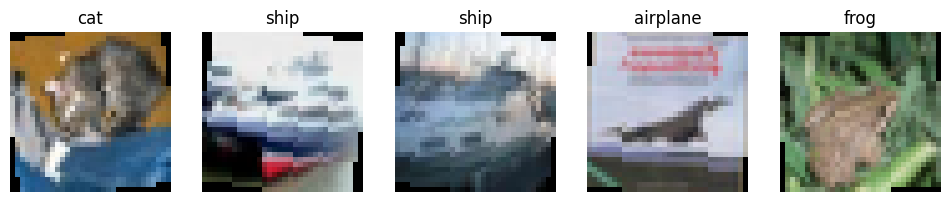

In [11]:
# Explore test data
show5(testloader)

## Build Your Neural Network

Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced.

In [12]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1) # Apply softmax to get class probabilities

In [13]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model. If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize the Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Running Your Neural Network

Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU.

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people.

In [15]:
losses = []
epochs = 30

for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}")

    # Step the scheduler to adjust learning rate
    scheduler.step()

Epoch 1, Loss: 2.069
Epoch 2, Loss: 1.936
Epoch 3, Loss: 1.876
Epoch 4, Loss: 1.845
Epoch 5, Loss: 1.823
Epoch 6, Loss: 1.789
Epoch 7, Loss: 1.776
Epoch 8, Loss: 1.767
Epoch 9, Loss: 1.759
Epoch 10, Loss: 1.755
Epoch 11, Loss: 1.738
Epoch 12, Loss: 1.731
Epoch 13, Loss: 1.727
Epoch 14, Loss: 1.724
Epoch 15, Loss: 1.721
Epoch 16, Loss: 1.713
Epoch 17, Loss: 1.711
Epoch 18, Loss: 1.709
Epoch 19, Loss: 1.705
Epoch 20, Loss: 1.705
Epoch 21, Loss: 1.701
Epoch 22, Loss: 1.699
Epoch 23, Loss: 1.697
Epoch 24, Loss: 1.696
Epoch 25, Loss: 1.694
Epoch 26, Loss: 1.694
Epoch 27, Loss: 1.693
Epoch 28, Loss: 1.692
Epoch 29, Loss: 1.691
Epoch 30, Loss: 1.692


Plot the training loss (and validation loss/accuracy, if recorded).

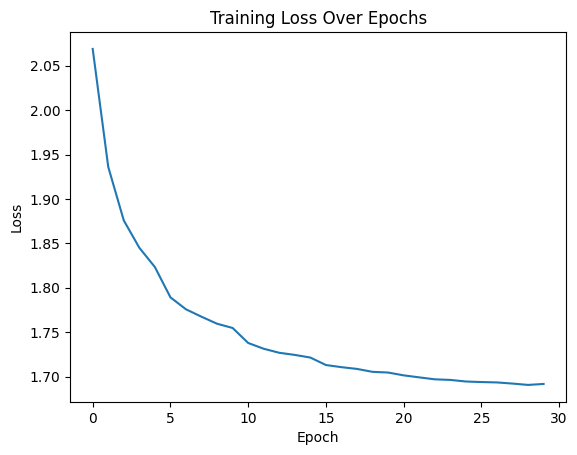

Finished Training


In [16]:
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

print("Finished Training")

## Testing Your model

Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! This is a hard task to exceed 70% on. If your accuracy is under 45%, you'll need to make improvements. Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
correct = 0
total = 0

with torch.no_grad():

    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 74.25%


## Saving Your Model

Using `torch.save`, save your model for future loading.

In [18]:
torch.save(model.state_dict(), "cifar10_model.pth")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:

1. How does your model compare to Detectocorp's model?
    - <font color='red'> My model achieved an accuracy of 74.25%, which surpasses Detectocorp's model accuracy of 70%. </font>
2. How does it compare to the far more advanced solutions in the literature?
    - <font color='red'> While my model doesn't match the state-of-the-art solutions like GPipe with 99% accuracy, it performs well considering resource constraints. </font>
3. What did you do to get the accuracy you achieved?
    - <font color='red'> To achieve this accuracy, I implemented a neural network with three convolutional layers, batch normalization, dropout for regularization, and an Adam optimizer with a learning rate scheduler. </font>
4. Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?
    - <font color='red'> Improving accuracy is beneficial but may require advanced techniques, such as data augmentation, deeper architectures, transfer learning, or ensembling methods. This will involve more computational resources and time. </font>